# Traveling Salesman Problem

<a target="_blank" href="https://colab.research.google.com/github/arthurrichards77/smply/blob/master/travelling_salesman.ipynb">
  <img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/>
</a>

This example shows how an optimization can be used to solve a Traveling Salesman Problem over a roadmap.

First we'll need some libraries including the [PuLP linear programming library](https://coin-or.github.io/pulp/).

In [1]:
import matplotlib.pyplot as plt
%matplotlib inline
import numpy as np
import random
!pip install pulp
from pulp import *

## Problem definition

Start by choosing 20 random locations.

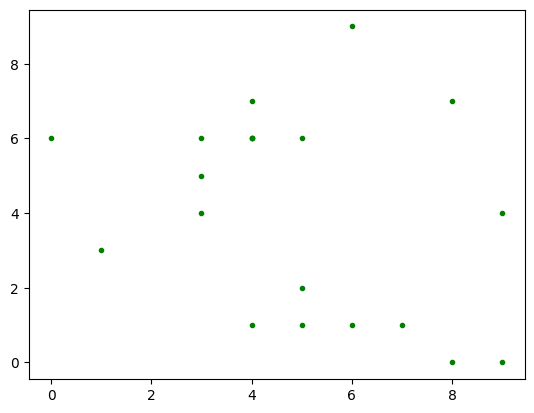

In [2]:
visit_points = np.array([[random.randrange(0,10), random.randrange(0,10)] for ii in range(20)])

plt.plot(visit_points[:,0], visit_points[:,1],'g.')
plt.show()

Now find the distances between them.  For simplicyt, I'll use straight line between all involved.  You could have `inf` values in here as well though - for example, the adjacency graph from any of the roadmap methods could be used.

In [3]:
from math import sqrt
distance = np.zeros((20,20))
for ii in range(20):
  for jj in range(ii,20):
    distance[ii,jj] = sqrt(sum((visit_points[ii,:]-visit_points[jj,:])**2))
    distance[jj,ii]=distance[ii,jj]
distance

array([[ 0.        ,  4.12310563,  1.        ,  7.21110255,  5.38516481,
         0.        ,  0.        ,  5.09901951,  5.        ,  5.83095189,
         2.23606798,  7.81024968,  1.41421356,  5.38516481,  1.        ,
         4.12310563,  3.60555128,  4.        ,  4.24264069,  1.        ],
       [ 4.12310563,  0.        ,  5.09901951,  3.60555128,  4.47213595,
         4.12310563,  4.12310563,  1.        ,  1.41421356,  2.23606798,
         2.82842712,  4.47213595,  3.60555128,  1.41421356,  4.47213595,
         5.83095189,  7.07106781,  6.40312424,  4.12310563,  4.        ],
       [ 1.        ,  5.09901951,  0.        ,  8.06225775,  5.83095189,
         1.        ,  1.        ,  6.08276253,  6.        ,  6.70820393,
         3.16227766,  8.60232527,  2.23606798,  6.32455532,  1.41421356,
         4.        ,  2.82842712,  4.12310563,  5.        ,  1.41421356],
       [ 7.21110255,  3.60555128,  8.06225775,  0.        ,  4.12310563,
         7.21110255,  7.21110255,  3.16227766,  

## The TSP bit

Now we've built the roadmap, instead of running an A-to-B search like Dijkstra's on it, let's find the shortest path that visits all points.

We solve this using integer linear optimization, using a library called PuLP to model and solve the problem.  First, get a list of all the possible moves or "links" and create a new optimization problem with a binary decision variable for each, $X(i,j) = \{0,1\} \ \forall i \ne j$.  We will intepret $X(i,j)=1$ to mean that the shortest path goes from $i$ to $j$.

In [4]:
n = len(visit_points)
links = [(i,j) for i in range(n) for j in range(n) if j!=i]

prob = LpProblem('tsp',LpMinimize)
x = LpVariable.dicts("x",links,0,1,LpInteger)

Define the objective to be the length of the path, which is the sum of all the decision variables weighted by the length of each link, $\sum_{i,j \ i \ne j} D(i,j)X(i,j)$. 

In [5]:
prob.setObjective(sum([distance[i,j]*x[i,j] for (i,j) in links]))


The main constraints are that the path must depart from every node exactly once $\sum_{j \in \mathcal{N}(i)} X(i,j) = 1 \ \forall i$ and also arrive at every node exactly once $\sum_{i  \in \mathcal{N}(j)} X(i,j)=1 \ \forall j$ where $\mathcal{N}(n)$ denotes the nodes connected to node $n$, in our case every other node.

In [6]:
for i in range(n):
    prob += (sum(x[ic,j] for (ic,j) in links if ic==i)==1)
for j in range(n):
    prob += (sum(x[i,jc] for (i,jc) in links if jc==j)==1)

One last issue: we could satisfy the constraints so far with two (or more) disconnected circuits or _tours_, provided the two covered all the nodes between them.  This isn;t what we're looking for.  There are various approaches to solving _the subtour problem_ but here we'll use extra variables $V(i)$ to extract the ordering of the visits, with a constraint ensuring $V(j) = V(i)+1$ if $X(i,j)=1$ for every $j>0$.  A subtour not including node $0$ would contradict this constraint as the ordering constraints would be circular: $3>2>1>3$.

In [7]:
v = LpVariable.dicts("v",range(n),0,n)
for (i,j) in links:
    if j!=0:
        prob += (v[j]>=v[i]+1-n*(1-x[i,j])) 

We can take a look at the problem and while it is pretty ugly, look closely and you can identify the elements of the model.

In [8]:
prob

tsp:
MINIMIZE
4.123105625617661*x_(0,_1) + 2.23606797749979*x_(0,_10) + 7.810249675906654*x_(0,_11) + 1.4142135623730951*x_(0,_12) + 5.385164807134504*x_(0,_13) + 1.0*x_(0,_14) + 4.123105625617661*x_(0,_15) + 3.605551275463989*x_(0,_16) + 4.0*x_(0,_17) + 4.242640687119285*x_(0,_18) + 1.0*x_(0,_19) + 1.0*x_(0,_2) + 7.211102550927978*x_(0,_3) + 5.385164807134504*x_(0,_4) + 5.0990195135927845*x_(0,_7) + 5.0*x_(0,_8) + 5.830951894845301*x_(0,_9) + 4.123105625617661*x_(1,_0) + 2.8284271247461903*x_(1,_10) + 4.47213595499958*x_(1,_11) + 3.605551275463989*x_(1,_12) + 1.4142135623730951*x_(1,_13) + 4.47213595499958*x_(1,_14) + 5.830951894845301*x_(1,_15) + 7.0710678118654755*x_(1,_16) + 6.4031242374328485*x_(1,_17) + 4.123105625617661*x_(1,_18) + 4.0*x_(1,_19) + 5.0990195135927845*x_(1,_2) + 3.605551275463989*x_(1,_3) + 4.47213595499958*x_(1,_4) + 4.123105625617661*x_(1,_5) + 4.123105625617661*x_(1,_6) + 1.0*x_(1,_7) + 1.4142135623730951*x_(1,_8) + 2.23606797749979*x_(1,_9) + 2.23606797749979*

Now we simply as PuLP to solve it and look at the result.

In [9]:
prob.solve()
print("Status:", LpStatus[prob.status])
[(i,j,x[i,j].value()) for (i,j) in links]

Welcome to the CBC MILP Solver 
Version: 2.10.3 
Build Date: Dec 15 2019 

command line - /Library/Frameworks/Python.framework/Versions/3.11/lib/python3.11/site-packages/pulp/solverdir/cbc/osx/64/cbc /var/folders/5v/8ygvppms6tj1217vhdh1b8f40000gn/T/65a2a176f4184095937303c3091c6563-pulp.mps timeMode elapsed branch printingOptions all solution /var/folders/5v/8ygvppms6tj1217vhdh1b8f40000gn/T/65a2a176f4184095937303c3091c6563-pulp.sol (default strategy 1)
At line 2 NAME          MODEL
At line 3 ROWS
At line 406 COLUMNS
At line 3384 RHS
At line 3786 BOUNDS
At line 4187 ENDATA
Problem MODEL has 401 rows, 400 columns and 1843 elements
Coin0008I MODEL read with 0 errors
Option for timeMode changed from cpu to elapsed
Continuous objective value is 31.3988 - 0.00 seconds
Cgl0003I 0 fixed, 0 tightened bounds, 19 strengthened rows, 0 substitutions
Cgl0003I 0 fixed, 0 tightened bounds, 19 strengthened rows, 0 substitutions
Cgl0003I 0 fixed, 0 tightened bounds, 19 strengthened rows, 0 substitutions


[(0, 1, 0.0),
 (0, 2, 0.0),
 (0, 3, 0.0),
 (0, 4, 0.0),
 (0, 5, 0.0),
 (0, 6, 1.0),
 (0, 7, 0.0),
 (0, 8, 0.0),
 (0, 9, 0.0),
 (0, 10, 0.0),
 (0, 11, 0.0),
 (0, 12, 0.0),
 (0, 13, 0.0),
 (0, 14, 0.0),
 (0, 15, 0.0),
 (0, 16, 0.0),
 (0, 17, 0.0),
 (0, 18, 0.0),
 (0, 19, 0.0),
 (1, 0, 0.0),
 (1, 2, 0.0),
 (1, 3, 0.0),
 (1, 4, 0.0),
 (1, 5, 0.0),
 (1, 6, 0.0),
 (1, 7, 0.0),
 (1, 8, 0.0),
 (1, 9, 0.0),
 (1, 10, 0.0),
 (1, 11, 0.0),
 (1, 12, 0.0),
 (1, 13, 1.0),
 (1, 14, 0.0),
 (1, 15, 0.0),
 (1, 16, 0.0),
 (1, 17, 0.0),
 (1, 18, 0.0),
 (1, 19, 0.0),
 (2, 0, 0.0),
 (2, 1, 0.0),
 (2, 3, 0.0),
 (2, 4, 0.0),
 (2, 5, 0.0),
 (2, 6, 0.0),
 (2, 7, 0.0),
 (2, 8, 0.0),
 (2, 9, 0.0),
 (2, 10, 0.0),
 (2, 11, 0.0),
 (2, 12, 0.0),
 (2, 13, 0.0),
 (2, 14, 0.0),
 (2, 15, 0.0),
 (2, 16, 0.0),
 (2, 17, 0.0),
 (2, 18, 0.0),
 (2, 19, 1.0),
 (3, 0, 0.0),
 (3, 1, 0.0),
 (3, 2, 0.0),
 (3, 4, 0.0),
 (3, 5, 0.0),
 (3, 6, 0.0),
 (3, 7, 0.0),
 (3, 8, 0.0),
 (3, 9, 0.0),
 (3, 10, 0.0),
 (3, 11, 1.0),
 (3, 12, 0.0),
 

Plot the results and we should have an efficient tour round all the points.

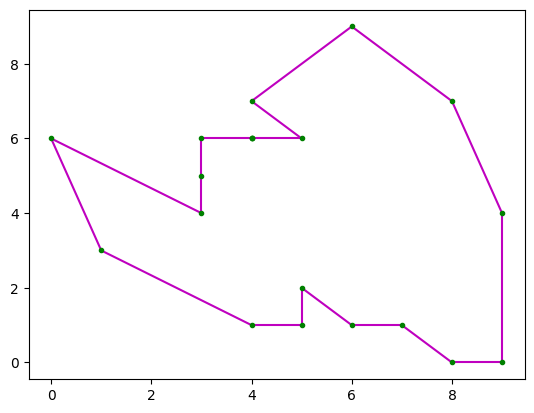

In [10]:
for (ii,jj) in links:
    if x[ii,jj].value()==1.:
        plt.plot([visit_points[ii,0],visit_points[jj,0]],[visit_points[ii,1],visit_points[jj,1]],'m-')
plt.plot(visit_points[:,0], visit_points[:,1],'g.')
plt.show()

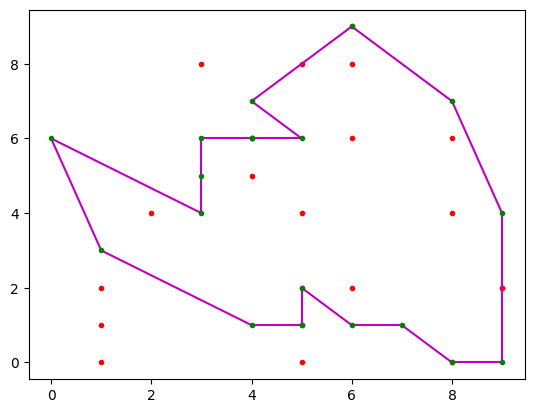

In [11]:
optional_points = np.array([[random.randrange(0,10), random.randrange(0,10)] for ii in range(20)])
plt.plot(optional_points[:,0], optional_points[:,1],'r.')


for (ii,jj) in links:
    if x[ii,jj].value()==1.:
        plt.plot([visit_points[ii,0],visit_points[jj,0]],[visit_points[ii,1],visit_points[jj,1]],'m-')
plt.plot(visit_points[:,0], visit_points[:,1],'g.')
plt.show()